In [ ]:
!pip install matplotlib gym pygame scikit-image

Tuesday 2/03/2021

* Added VAE
 * Latent space became zero-centered
 * Decoder started to work great, very clear reconstructed image

NEXT:

* Colormap latent space scatter plots

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%load_ext tensorboard

## Dataset

In [ ]:
from env import ArmRobotEnv
env = ArmRobotEnv()

### Generate

In [ ]:
import time

def gen_data(N):
    """
    Generate testdata: actions and robot views
    """
    env.reset()

    print("Generating %d datapoints ... (approx %f sec)" % (N, N*0.035)) # FIXME
    
    start_time = time.time()
    for i in range(N):
        action = env.env.action_space.sample()
        obs, _reward, _done, _info = env.step(action)
        env.render()
        y = env.get_image()
        
        if i == 0:
            A = np.zeros([N] + list(action.shape))
            Y = np.zeros([N] + list(y.shape))

        A[i] = action.flatten()
        Y[i] = y
  
    elapsed = time.time() - start_time
    print("Generated %d data points. Actual time: %.1fs (%f sec/datapoint)" % (N, elapsed, elapsed/N))

    return {'A': A, 'Y': Y}

In [ ]:
#gen_data(10)['Y'].shape

### Load the dataset

In [2]:
import pickle
with open('dataset-random-100k.mdict.pickle', 'rb') as handle:
    [train, val, test] = pickle.load(handle)

print(train['Y'].shape)
print(train.keys())

(100000, 64, 64, 1)
dict_keys(['A', 'Y'])


### Visualize statistical distribution of the dataset

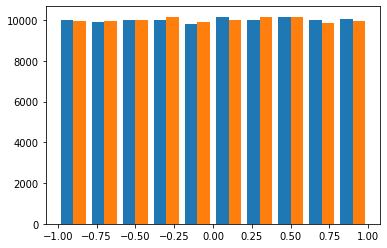

In [3]:
_=plt.hist(train['A'])

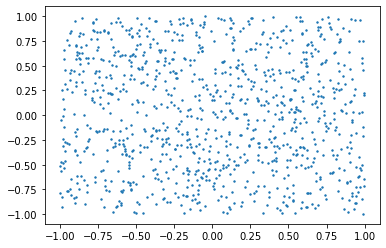

In [7]:
_=plt.scatter(train['A'][:1000,0], train['A'][:1000,1], 2)

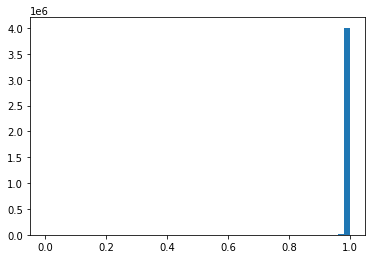

In [8]:
_=plt.hist(train['Y'][:1000].flatten(), bins=50)

### Visualize some images from the dataset

In [9]:
def _clean_ax(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
def _imshow(ax, img):
    if img is not None:
        ax.imshow(img, cmap='Greys', origin='lower')
    _clean_ax(ax)
        
def plot_Y(img_array):
    assert(img_array.shape[-1] == 1)
    fig, axs = plt.subplots(figsize=(2, 2))
    _imshow(axs, img_array[..., 0])
    return fig, axs

def plot_Ys(img_array, title=None, ncols=5):
    assert(ncols > 0)

    nimgs = img_array.shape[0]
    if nimgs == 0:
        return None, None
    elif nimgs == 1:
        return plot_Y(img_array[0,...])
    elif nimgs <= ncols:
        ncols = nimgs
        fig, axs = plt.subplots(1, ncols, figsize=(2*ncols, 2))

        for i in range(ncols):
            _imshow(axs[i], img_array[i,...])
    else:
        nrows = int((nimgs-1)/ ncols) + 1
        fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

        for i in range(nrows):
            for j in range(ncols):
                k = i*ncols + j
                if k < nimgs:
                    img = img_array[k,...]
                else:
                    img = None
                _imshow(axs[i][j], img)
                    
    if title is not None:
        fig.suptitle("%s (%s)" % (title, str(img_array.shape)))
        
    return fig, axs

In [10]:
#_=plot_Y(train_Y[0,...])
#_=plot_Ys(train_Y[0:1,...])
#_=plot_Ys(train_Y[0:5,...])
#_=plot_Ys(train_Y[0:6,...])
#_=plot_Ys(train_Y[0:24,...])

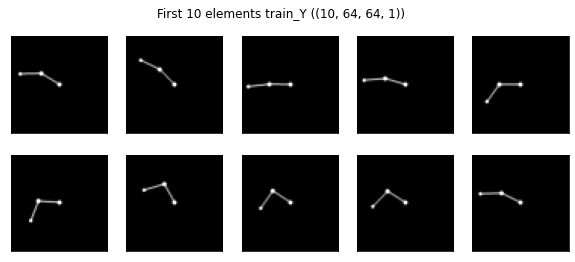

In [11]:
_=plot_Ys(train['Y'][0:10,...], title="First 10 elements train_Y")

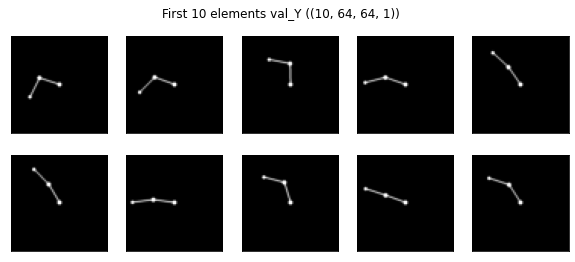

In [12]:
_=plot_Ys(val['Y'][0:10,...], title="First 10 elements val_Y")

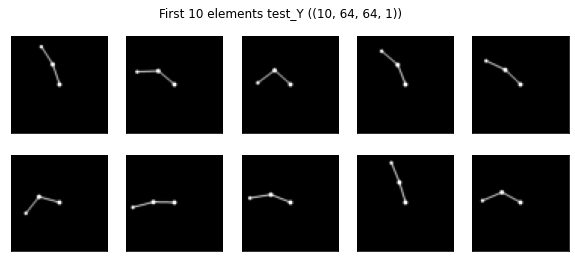

In [13]:
_=plot_Ys(test['Y'][0:10,...], title="First 10 elements test_Y")

## Model

### Implementations of model save and load methods

In [15]:
def save_models(model, prefix):
    model['ae'].save(prefix + '-ae.h5')
    model['enc'].save(prefix + '-enc.h5')
    model['dec'].save(prefix + '-dec.h5')
    print("Models saved to " + prefix + " ...")

def load_models(prefix):
    model = dict()
    for k in ['ae', 'enc', 'dec']:
        fname = prefix + '-' + k + '.h5'
        model[k] = keras.models.load_model(fname)
    return model

# VAE models cannot be saved by the above methods, can only save weights

def save_models_weights(model, prefix):
    model['ae'].save_weights(prefix + '-ae.h5w')
    model['enc'].save_weights(prefix + '-enc.h5w')
    model['dec'].save_weights(prefix + '-dec.h5w')
    print("Models weights saved to " + prefix + " ...")
    
def load_models_weights(model, prefix):
    model['ae'].load_weights(prefix + '-ae.h5w')
    model['enc'].load_weights(prefix + '-enc.h5w')
    model['dec'].load_weights(prefix + '-dec.h5w')

In [16]:
#autoencoder = load_models("autoencoder-double100k-2")
#save_models_weights(autoencoder, "20210301-vae")

### Build VAE

In [18]:
from models.vae import build_autoencoder
autoencoder = build_autoencoder(train['Y'].shape[1:], 2)
load_models_weights(autoencoder, "20210302-vae") # NB: build the model first

### Train

In [ ]:
import os, datetime

def train_model(model, train, val):
    ae = model['ae']
    
    logdir = os.path.join("20210302-vae", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir) #, histogram_freq=1)
    
    ae.fit(train['Y'], validation_data=(val['Y'], val['Y']), callbacks=[tensorboard_callback],
        epochs=50, batch_size=128, verbose=1)

In [ ]:
train_model(autoencoder, train, val)

### Run

Y.shape=(100000, 64, 64, 1)
L.shape=(3, 100000, 2)
YY.shape=(100000, 64, 64, 1)


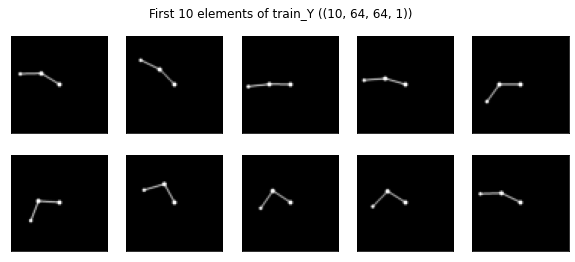

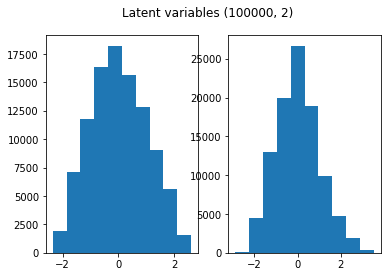

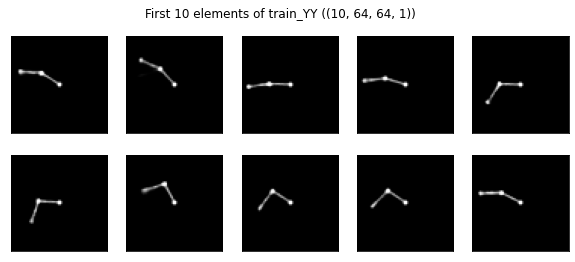

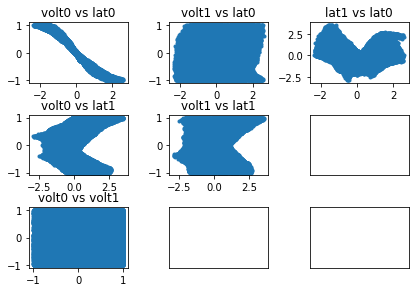

In [26]:
_=cycle_autoencoder(autoencoder, train, prefix="train_", vae=True)

Y.shape=(100, 64, 64, 1)
L.shape=(3, 100, 2)
YY.shape=(100, 64, 64, 1)


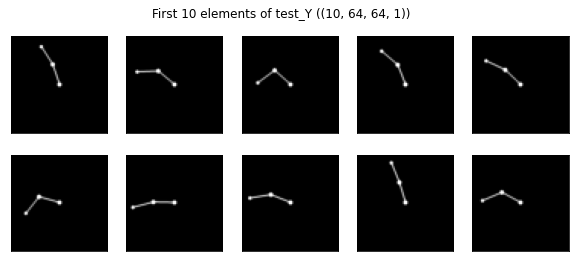

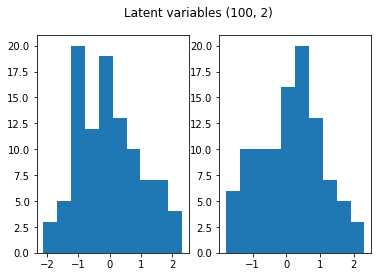

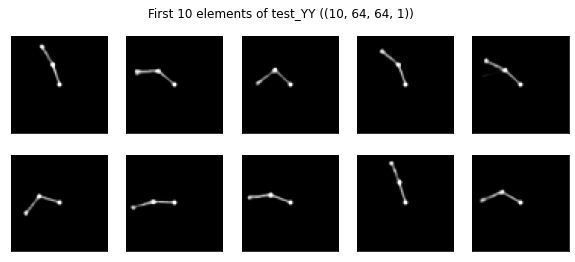

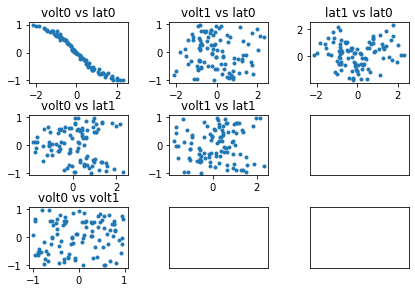

In [27]:
_=cycle_autoencoder(autoencoder, test, prefix="test_", vae=True)

Y.shape=(100, 64, 64, 1)
L.shape=(3, 100, 2)
YY.shape=(100, 64, 64, 1)


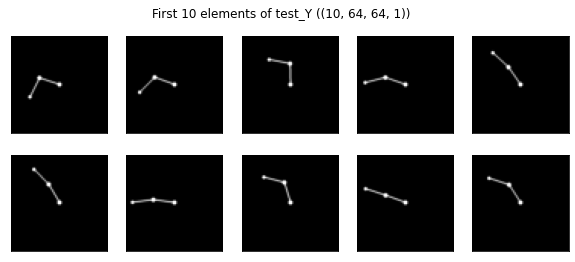

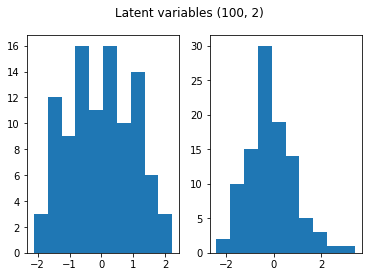

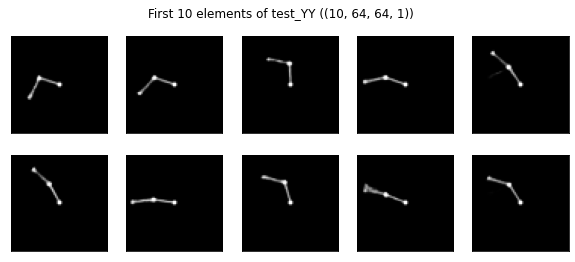

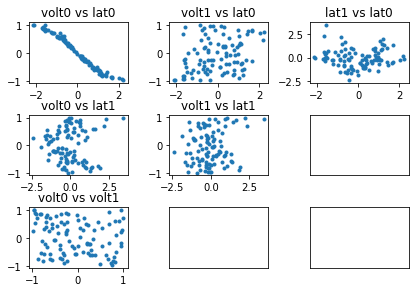

In [28]:
_=cycle_autoencoder(autoencoder, val, prefix="test_", vae=True)

### Run against yet another dataset

In [19]:
import pickle

def load_dataset(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

def save_dataset(dataset, filename):
    # https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    with open(filename, 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Dataset saved in %s" % filename)

In [35]:
new_val = load_dataset('dataset-linspace-40k.pickle')

Y.shape=(40000, 64, 64, 1)
L.shape=(3, 40000, 2)
YY.shape=(40000, 64, 64, 1)


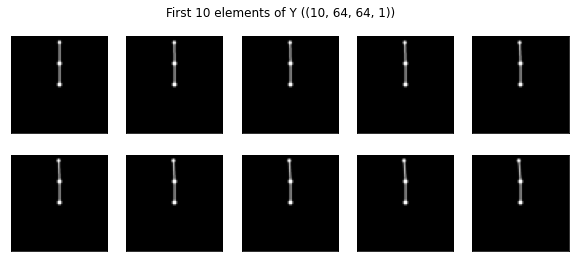

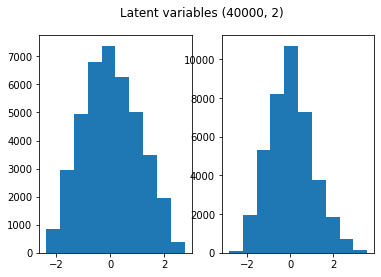

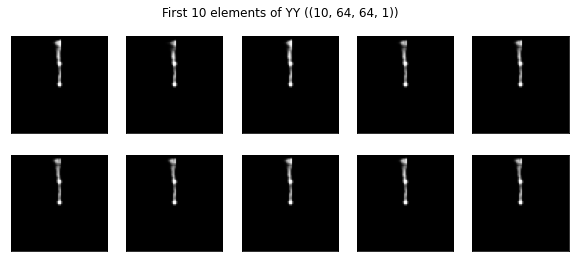

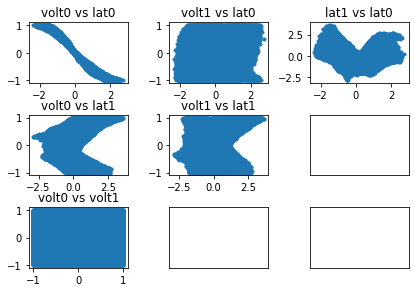

In [36]:
new_val_out = cycle_autoencoder(autoencoder, new_data, vae=True)

### Fine scatterplot visualization

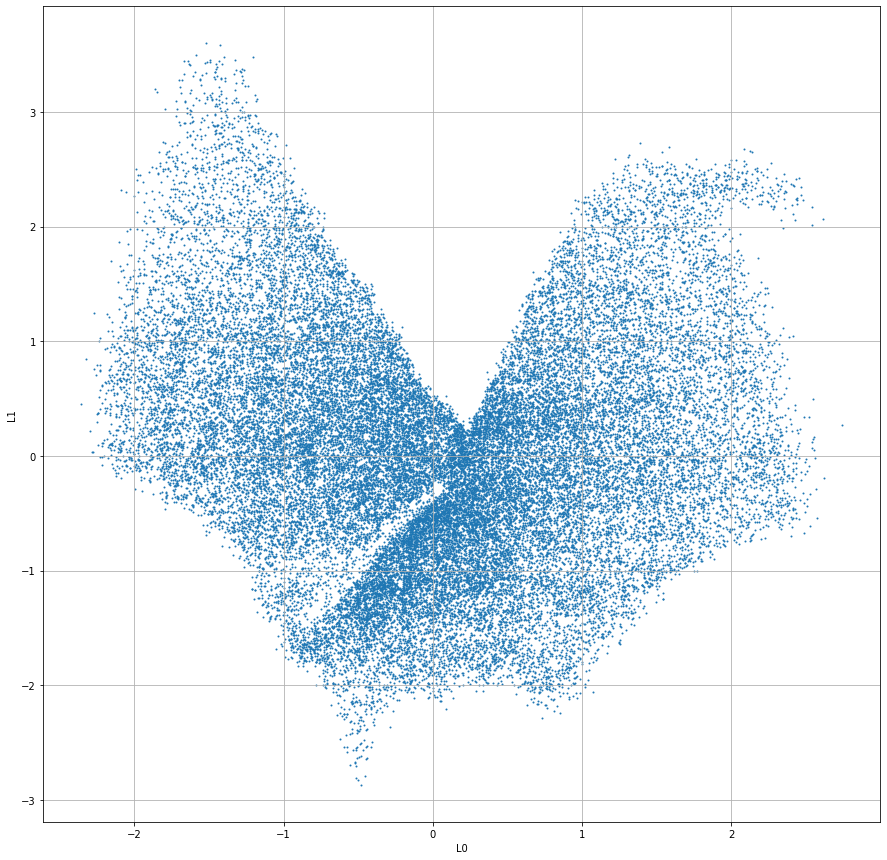

In [37]:
fine_scatter(new_val_out, 'L', 0, new_val_out, 'L' , 1)

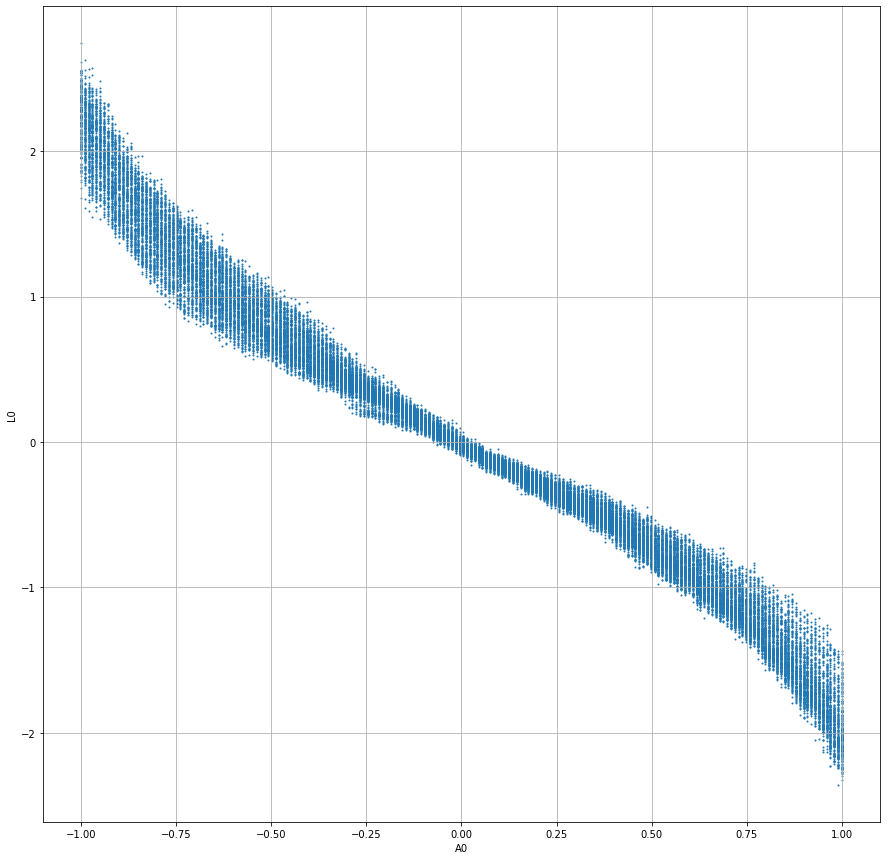

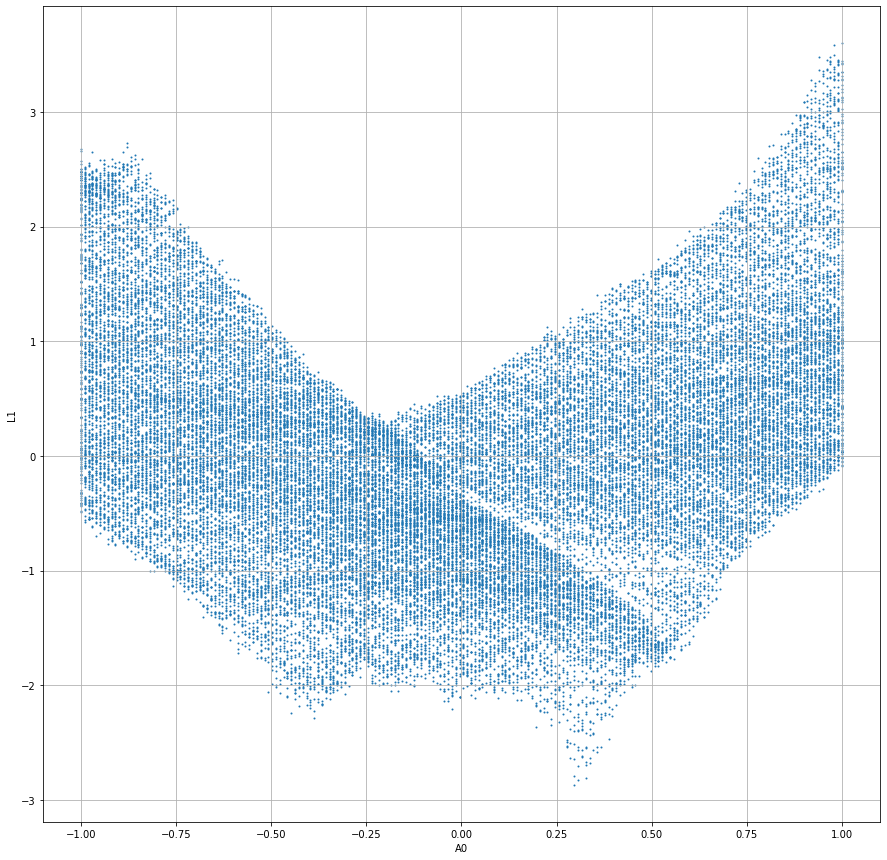

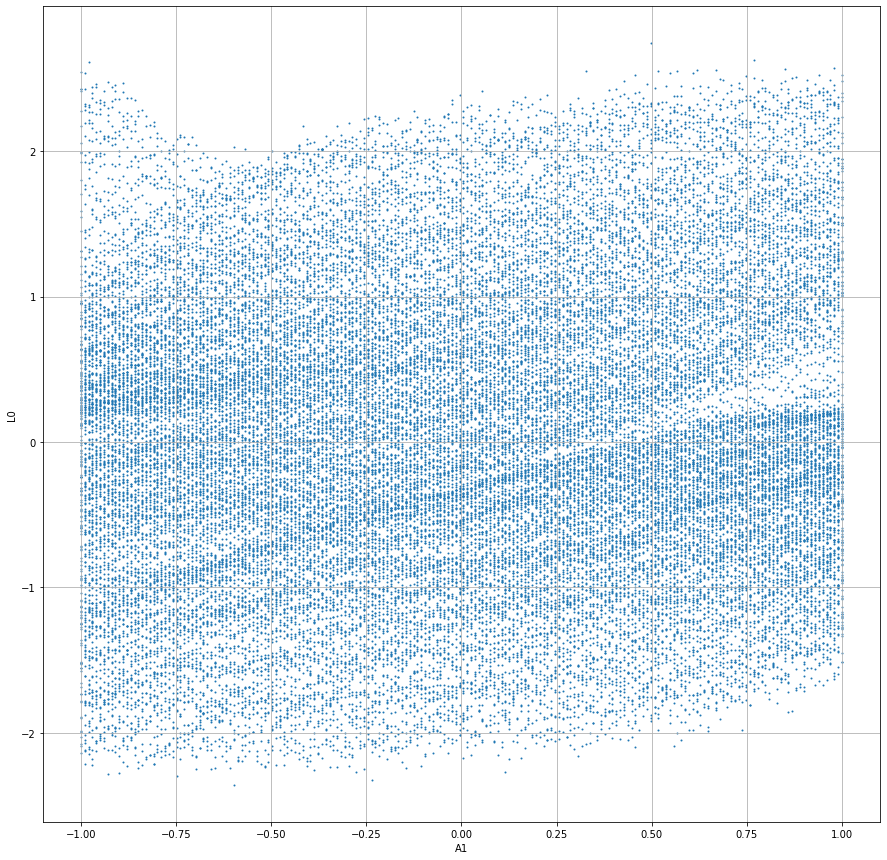

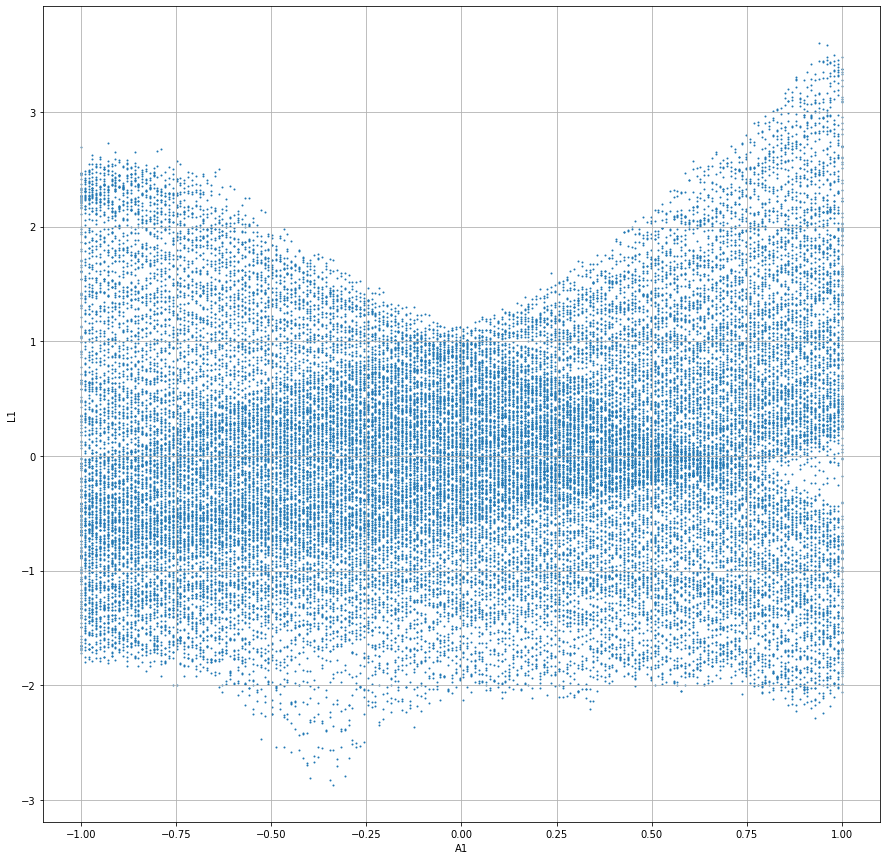

In [38]:
fine_scatter(new_val, 'A', 0, new_val_out, 'L' , 0)
fine_scatter(new_val, 'A', 0, new_val_out, 'L' , 1)
fine_scatter(new_val, 'A', 1, new_val_out, 'L' , 0)
fine_scatter(new_val, 'A', 1, new_val_out, 'L' , 1)


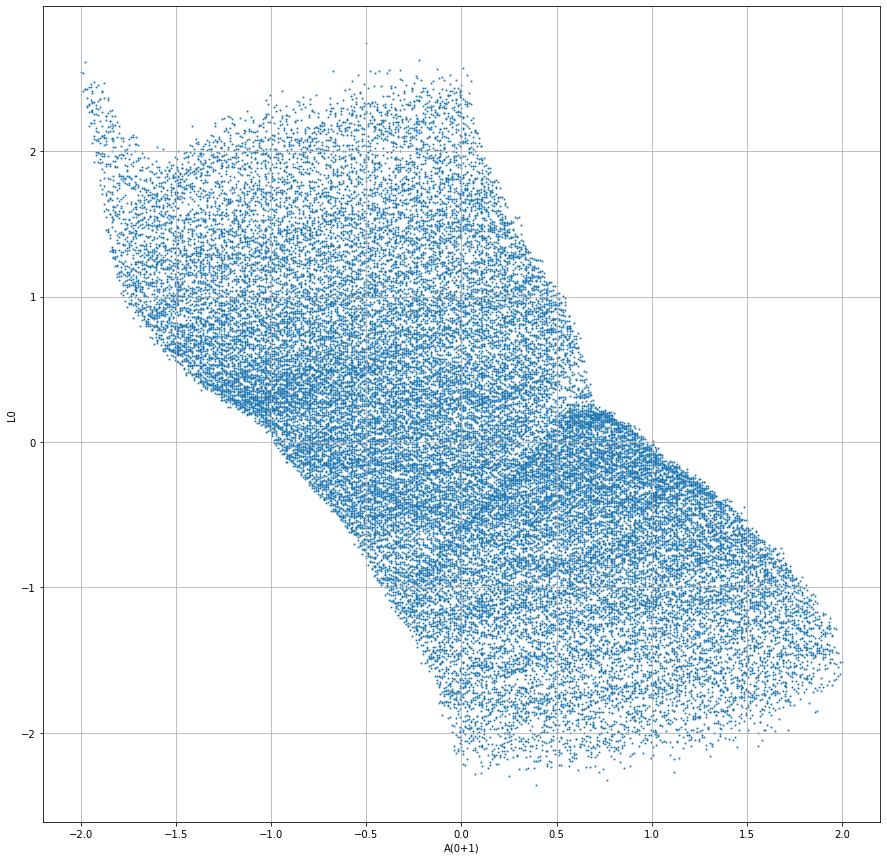

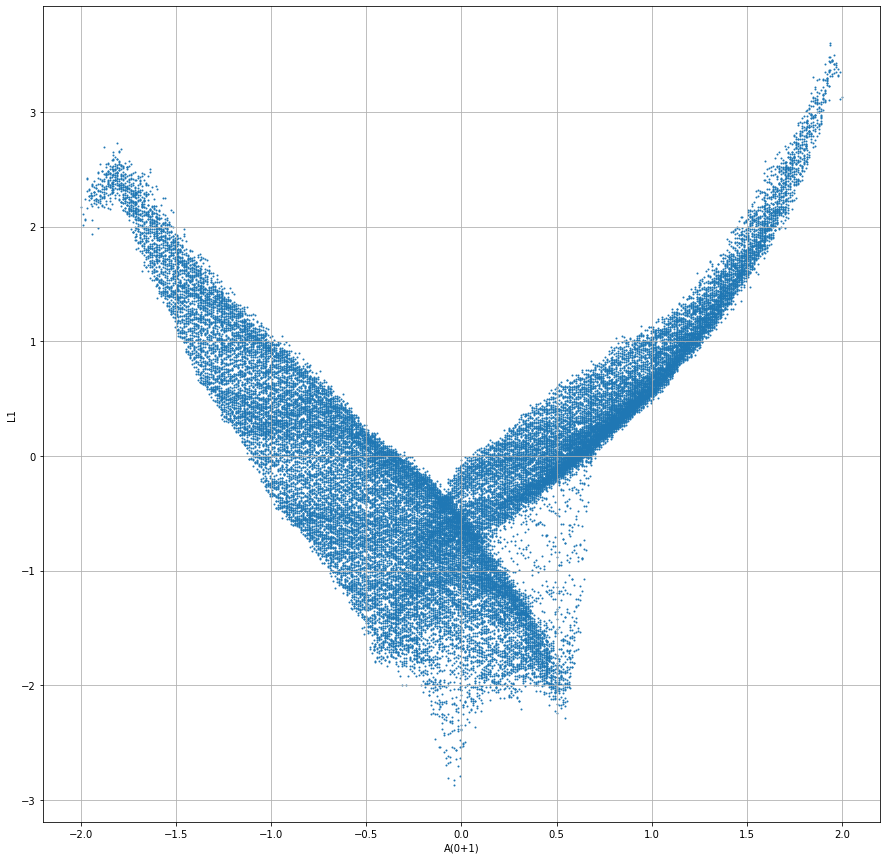

In [39]:
fine_scatter_sum(new_val, 'A', 0, 1, new_val_out, 'L', 0)
fine_scatter_sum(new_val, 'A', 0, 1, new_val_out, 'L', 1)

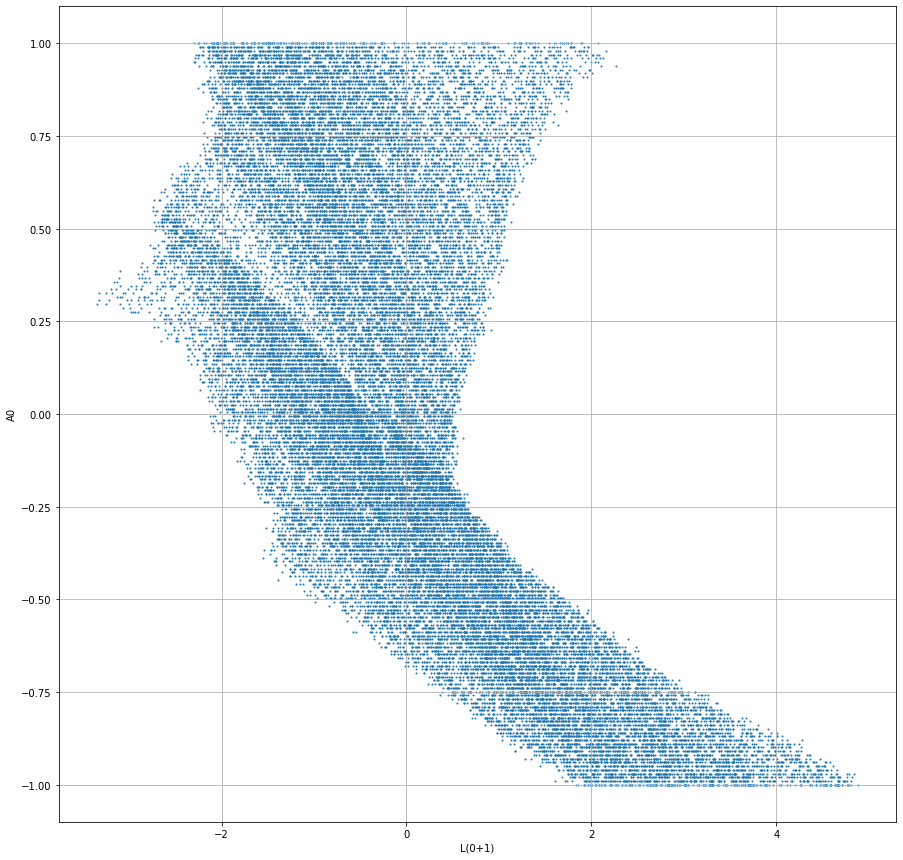

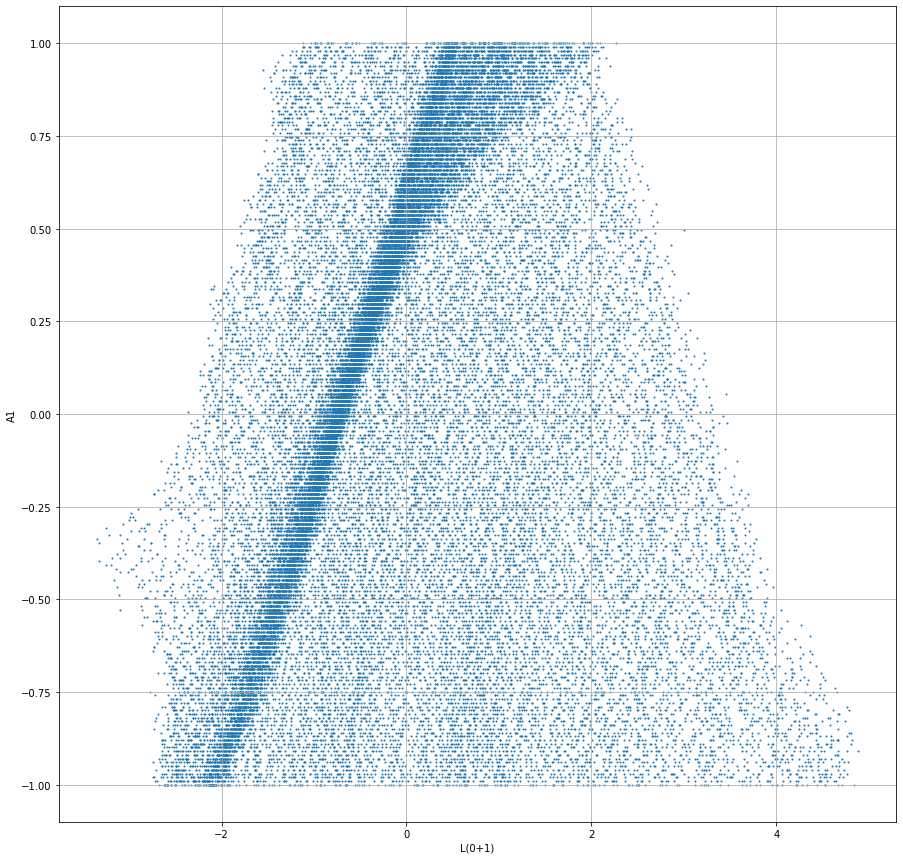

In [40]:
fine_scatter_sum(new_val_out, 'L', 0, 1, new_val, 'A', 0)
fine_scatter_sum(new_val_out, 'L', 0, 1, new_val, 'A', 1)

In [ ]:
play_with_sliders(autoencoder, [[-2,2], [-2,2]])

# Tools

## Visualize performance of the model

In [25]:
def fine_scatter(data1, x1, i1, data2, x2, i2):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(data1[x1][:,i1], data2[x2][:,i2], 1)
    ax.set_xlabel("%s%d" % (x1, i1))
    ax.set_ylabel("%s%d" % (x2, i2))
    ax.grid()

def fine_scatter_sum(data1, x1, i1a, i1b, data2, x2, i2):
    fig, ax = plt.subplots(figsize=(15, 15))

    x = data1[x1][:,i1a] + data1[x1][:,i1b]
    ax.scatter(x, data2[x2][:,i2], 1)
    
    ax.set_xlabel("%s(%d+%d)" % (x1, i1a, i1b))
    ax.set_ylabel("%s%d" % (x2, i2))
    ax.grid()
    
def display_xvars(data):
    nLat = data['L'].shape[1]
    nVoltages = data['A'].shape[1]

    fig, axs = plt.subplots(nLat+1, nVoltages+1)
    fig.tight_layout()

    for i in range(nLat):
      for j in range(nVoltages):
        title = "volt%d vs lat%d" % (j, i)
        axs[i][j].title.set_text(title)
        axs[i][j].plot(data['L'][:, i], data['A'][:,j], '.')

    axs[nLat][0].title.set_text("volt0 vs volt1")
    axs[nLat][0].plot(data['A'][:,1], data['A'][:,0], '.')

    axs[0][nVoltages].title.set_text("lat1 vs lat0")
    axs[0][nVoltages].plot(data['L'][:,0], data['L'][:,1], '.')

    _clean_ax(axs[1][2])
    _clean_ax(axs[2][1])
    _clean_ax(axs[2][2])

def cycle_autoencoder0(ae, data, prefix="", N=10):
    out_data = dict()
    
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    YY = ae['ae'].predict(Y)
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    out_data['YY'] = YY

    # - Y
    plot_Ys(Y[0:N,...], title="First %d elements of %sY" % (N, prefix))
   
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
    
    return out_data

def cycle_autoencoder(ae, data, prefix="", N=10, vae=False):
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    L = ae['enc'].predict(Y)
    L = np.array(L)
    print("L.shape=" + str(L.shape))

    if vae:
        L = np.array(L)[2] # [z_mean, z_log_var, z] - take Z

    YY = ae['dec'].predict(L)
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    data['L'] = L # FIXME
    data['YY'] = YY # FIXME

    out_data = dict()
    out_data['L'] = L
    out_data['YY'] = YY

    # - Y
    plot_Ys(Y[0:N,...], title="First %d elements of %sY" % (N, prefix))

    # - L
    fig, axs = plt.subplots(1, L.shape[1])
    fig.suptitle("Latent variables %s" % (str(L.shape)))
    for i in range(L.shape[1]):
        axs[i].hist(L[:,i])    
    
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
    
    display_xvars(data)
    
    return out_data    

In [ ]:
#cycle_autoencoder0(autoencoder, train, prefix="train_")

In [ ]:
#cycle_autoencoder(autoencoder, train, prefix="train_")

In [ ]:
#cycle_autoencoder(autoencoder, val, prefix="val_")

In [ ]:
#cycle_autoencoder(autoencoder, test, prefix="test_")

## Play with Sliders

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def play_with_sliders(ae, ranges):
    nlats = len(ranges)
    
    sliders = []
    for i in range(nlats):
        sliders.append(widgets.FloatSlider(value=0.0, min=ranges[i][0], max=ranges[i][1], step=0.01))

    button = widgets.Button(description="Redraw")
    output = widgets.Output()

    def redraw(_=None):
        with output:
            output.clear_output(wait=True)
            #print("# %f %f" % (slider0.value, slider1.value))

            lats = []
            for i in range(nlats):
                lats.append(sliders[i].value)
                
            L = np.array([np.array(lats)])
            print(L.shape)
            Ys = ae['dec'].predict(L)[0,...,0]

            plt.clf()
            plt.imshow(Ys, cmap='Greys')
            plt.show()

    # ---
    
    ws = [output]
    
    for i in range(nlats):
        sliders[i].observe(redraw, names='value')
        ws.append(sliders[i])
        
    ws.append(button)
    button.on_click(redraw)
    
    display(*ws)
    redraw()

In [ ]:
#play_with_sliders(autoencoder, [[2, 10], [-5,-1]])